# Data preprocessing functions

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### 1) Load Image from archive, extract grayscale value and normolized to 0-1

In [2]:
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]

i = 0
print("=======starting======")
for fileName in files:
    image=tf.keras.utils.load_img(os.path.join(directory,fileName),color_mode='grayscale',target_size=(100,100))
    image=tf.keras.utils.img_to_array(image)
    image=image/255.0
    imageDatas+=[image]
    i = i + 1
    if (i % 500 == 0):
        print(i)

class_names = dataset["label"].unique()
print(class_names)
print("=======done======")

=======starting======
500
1000
1500
2000
2500
3000
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
=======done======


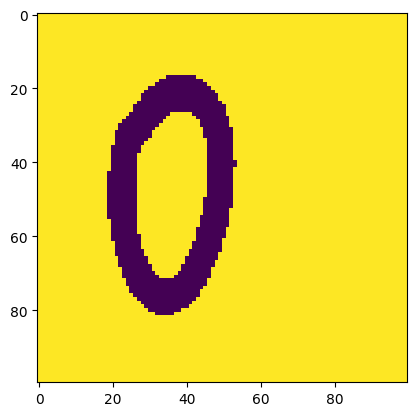

label:  0


In [3]:
plt.imshow(imageDatas[0])
plt.show()

print("label: ", label[0])

In [4]:
import numpy
dimention = "100x100"
npzFileName = "Uncompressed_" + dimention + ".npz"

imageDatas_np = np.array(imageDatas)
# Save compressed data to NPZ file
numpy.savez(npzFileName, imageDatas_np=imageDatas_np)
print("=======done saving======")

=======done saving======


### 2) Center the letter

In [6]:
def centerChar(Img):
    dimension = len(Img)
    location = locatChar(Img)
    
    resultImg = []
    for i in range(dimension):
        row = []
        for j in range(dimension):
            row += [[np.float32(1.0)]]
            
        resultImg += [row]
    
    offset_row = int((dimension-(location[1] + 1 -location[0]))/2)    
    offset_col = int((dimension-(location[3] + 1 -location[2]))/2)
    
    for i in range(0, location[1] + 1 - location[0]):
        for j in range(0, location[3] + 1 - location[2]):
            resultImg[i + offset_row][j + offset_col][0] = Img[i + location[0]][j + location[2]][0]
    
    
    resultImg = np.array(resultImg)
    return resultImg
    
def locatChar(Img):
    dimension = len(Img)
    top = dimension
    bottom = 0
    left = dimension
    right = 0
    
    for i in range(dimension):
        for j in range(dimension):
            if Img[i][j][0] < 0.2:
                if top > i:
                    top = i
                if bottom < i:
                    bottom = i
                if left > j:
                    left = j
                if right < j:
                    right = j
    return [top, bottom, left, right]

In [9]:
ImageData_centered = []
count = 0
print("=====start processing=====")
for img in imageDatas:
    img_c = centerChar(img)
    ImageData_centered += [img_c]
    
    count += 1
    if (count % 500 == 0):
        print("processed: ", count, " imgs" )

print("=====finish processing=====")

ImageData_centered = np.array(ImageData_centered)
print(ImageData_centered.shape)

=====start processing=====
processed:  500  imgs
processed:  1000  imgs
processed:  1500  imgs
processed:  2000  imgs
processed:  2500  imgs
processed:  3000  imgs
=====finish processing=====
(3410, 100, 100, 1)


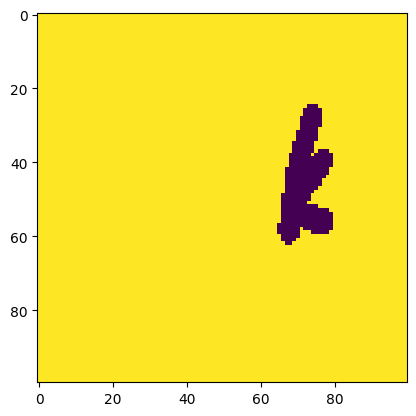

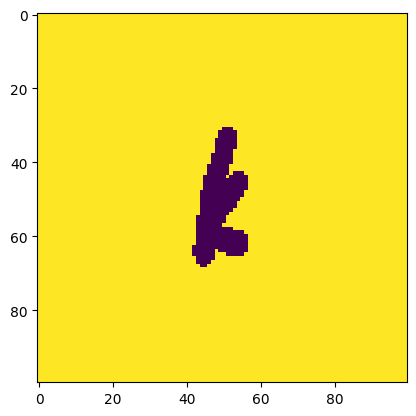

In [11]:
plt.imshow(imageDatas[2578])
plt.show()
plt.imshow(ImageData_centered[2578])
plt.show()

In [12]:
import numpy
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Save compressed data to NPZ file
numpy.savez(npzFileName, ImageData_centered=ImageData_centered)
print("=======done saving======")

=======done saving======


### 3) Coustomized Dataset splitting & onehot encoding

In [13]:
def getIndex(letter):
    index = ord(letter)-48
    if (index > 10):
        index -= 7
    if (index > 35):
        index -= 6
    return index

In [14]:
import random

data_nparr = ImageData_centered
label_nparr = np.array(label)

test_index = []
# Randomly select 6 items from each group of 55
selected_indices = []
print(label_nparr.shape)
for i in range(0, len(label_nparr), 55):
    charGroup = data_nparr[i:i+55]
    indices = random.sample(range(i, i+55), 10)
    test_index.extend(indices)

test_index_nparr = np.array(test_index)
print(test_index_nparr.shape)

train_data, test_data, train_label, test_label = [], [], [], []
for i in range(len(label_nparr)):
    if i in test_index:
        test_data += [data_nparr[i]]
        test_label += [getIndex(label_nparr[i])]
    else:
        train_data += [data_nparr[i]]
        train_label += [getIndex(label_nparr[i])]

train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

train_label_onehot = pd.get_dummies(train_label) # one-hot enc
test_label_onehot = pd.get_dummies(test_label) # one-hot enc

print(train_data.shape)

(3410,)
(620,)
(2790, 100, 100, 1)


# Data preporcessing attemps (not utlized in final model)

### 1) Dataset augmentation

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image

def apply_rotation_augmentation(images):
    # Convert the images to TensorFlow tensors
    images_tensor = tf.convert_to_tensor(images)

    # Reshape the images tensor to (some_amount, height, width, channels)
    images_tensor = tf.reshape(images_tensor, [len(images), 100, 100, 1])

    # Generate random rotation angles between -5 and 5 degrees for each image
    rotation_angles = tf.random.uniform(shape=[len(images)], minval=-10, maxval=10)

    # Apply rotation augmentation and resize to each image
    rotated_images = []
    for i in range(len(images)):
        img = tf.keras.preprocessing.image.array_to_img(images_tensor[i])
        img = img.rotate(rotation_angles[i])
        img = img.resize((116, 116), resample=Image.NEAREST)
        img = img.crop((8, 8, 108, 108)) 
        rotated_img = tf.keras.preprocessing.image.img_to_array(img)
        rotated_images.append(rotated_img)
    
    rotated_images = tf.convert_to_tensor(rotated_images)

    return rotated_images

In [18]:
train_data_augmented = train_data
print("=============Start Augmentation=============")
for i in range(5):
    train_data_augmented = np.concatenate((train_data_augmented, apply_rotation_augmentation(train_data[i * 500:(i + 1) * 500])), axis=0)
    print("processed ", (i + 1) * 500, " Img")
    
train_data_augmented = np.concatenate((train_data_augmented, apply_rotation_augmentation(train_data[2500:2790])), axis=0)
print("=============Finish Augmentation=============")
print(train_data_augmented.shape)

=============Start Augmentation=============
processed  500  Img
processed  1000  Img
processed  1500  Img
processed  2000  Img
processed  2500  Img
=============Finish Augmentation=============
(5580, 100, 100, 1)


In [20]:
train_label_augmented = np.concatenate((train_label, train_label), axis=0)
train_label_augmented_onehot = pd.get_dummies(train_label_augmented)
print(train_label.shape)
print(train_label_augmented_onehot.shape)

(2790,)
(5580, 62)


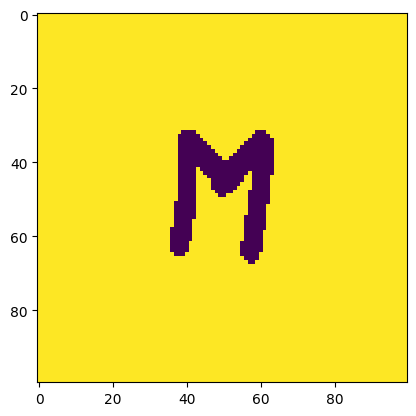

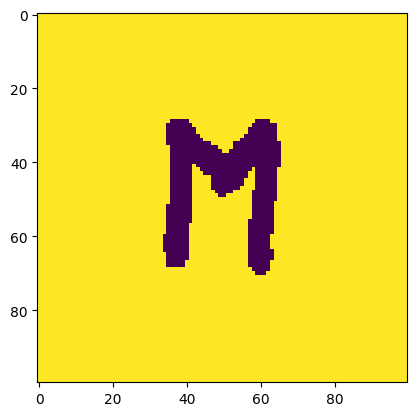

In [21]:
index_check = 1000;
plt.imshow(train_data_augmented[index_check])
plt.show()
plt.imshow(train_data_augmented[index_check + 2790])
plt.show()

### 2) Compress Image matrix

(100, 100, 1)
=====start compressing=====
compressed:  500  imgs
compressed:  1000  imgs
compressed:  1500  imgs
compressed:  2000  imgs
compressed:  2500  imgs
compressed:  3000  imgs
=====done compressing=====
(3410, 20, 20, 1)


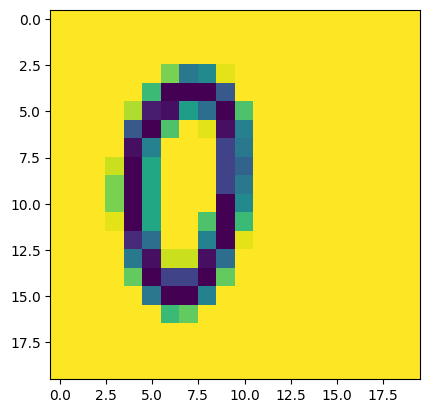

In [22]:
ImageData_compressed = []

print(np.array(imageDatas[0]).shape) 


count = 0
print("=====start compressing=====")
for img in imageDatas:
    img_compressed = []
    for i in range(20):
        row_compressed = []
        for j in range(20):
            sum = 0
            for r in range(5):
                for c in range(5):
                    sum += img[5 * i + r][5 *j + c]
            row_compressed += [sum/25]
            # print(np.array(row_compressed).shape)
            
        img_compressed += [row_compressed]
        # print(np.array(img_compressed).shape)
    ImageData_compressed += [img_compressed]
    count += 1
    if (count % 500 == 0):
        print("compressed: ", count, " imgs" )

print("=====done compressing=====")
print(np.array(ImageData_compressed).shape)
plt.imshow(ImageData_compressed[0])
# print(ImageData_compressed[0])
plt.show()

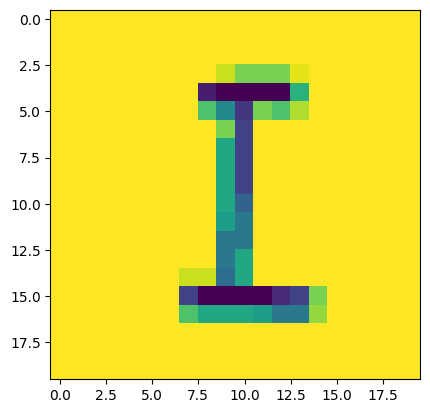

In [23]:
plt.imshow(ImageData_compressed[1032])
plt.show()